# Neural Architecture Search for Graph Neural Networks

## Install Deepchem and RDKit

We need deepchem for the benchmark datasets. RDKit is also required to convert molecule smile string to a graph representation.

In [ ]:
!pip install deepchem
!conda install -c rdkit rdkit

## Imports and GPU Detection <a class="anchor" id="imports-and-gpu-detection"></a>

<div class="alert alert-warning">

<b>Warning</b>
    
By design asyncio does not allow nested event loops. Jupyter is using Tornado which already starts an event loop. Therefore the following patch is required to run this tutorial.
    
</div>

In [1]:
!pip install nest_asyncio

import nest_asyncio
nest_asyncio.apply()

In [2]:
import json
import os
import pathlib
import shutil

!export TF_CPP_MIN_LOG_LEVEL=3
!export TF_XLA_FLAGS=--tf_xla_enable_xla_devices

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

<div class="alert alert-info">
    
<b>Note</b>
    
The `TF_CPP_MIN_LOG_LEVEL` can be used to avoid the logging of Tensorflow *DEBUG*, *INFO* and *WARNING* statements.
    
</div>

<div class="alert alert-info">
    
<b>Note</b>
    
The following can be used to detect if **GPU** devices are available on the current host.
    
</div>

In [3]:
available_gpus = tf.config.list_physical_devices("GPU")
n_gpus = len(available_gpus)
if n_gpus > 1:
    n_gpus -= 1
is_gpu_available = n_gpus > 0

if is_gpu_available:
    print(f"{n_gpus} GPU{'s are' if n_gpus > 1 else ' is'} available.")
else:
    print("No GPU available")

No GPU available


## Start Ray

We launch the Ray run-time depending on the detected local ressources. If GPU(s) is(are) detected then 1 worker is started for each GPU. If not, then only 1 worker is started. You can start more workers by setting `num_cpus=1` to a value greater than 1.

<div class="alert alert-warning">

<b>Warning</b>
    
In the case of GPUs it is important to follow this scheme to avoid multiple processes (Ray workers vs current process) to lock the same GPU.
    
</div>

In [4]:
import ray

if not(ray.is_initialized()):
    if is_gpu_available:
        ray.init(num_cpus=n_gpus, num_gpus=n_gpus, log_to_driver=False)            
    else:
        ray.init(num_cpus=4, log_to_driver=False)

2021-11-15 08:40:56,017	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


## Reformatting Graph Dataset <a class="anchor" id="a-synthetic-dataset"></a>

Now, we will start by reformatting a benchmark QM7 from molecule-net. We will first generate data for a **training set** (used for estimation) and a **testing set** (used to evaluate the final performance). Then the training set will be sub-divided in a new **training set** (used to estimate the neural network weights) and **validation set** (used to estimate the neural network hyperparameters and architecture).

The data is converted from a deepchem weave object to a list containing node features, edge features, edge pairs, node masks and GCN attention coefficients. You may check the details here https://ieeexplore.ieee.org/abstract/document/9378060

In [5]:
from deepchem.molnet import load_qm7
from deephyper.layers._mpnn import get_all_mol_feat

def load_data(test_only=0, verbose=0):
    _, (train_data, valid_data, test_data), _ = load_qm7(featurizer='Weave',
                                                         splitter='random')

    max_node, max_edge = [], [] # used to zero-pad the node and edge features to maximum dimension

    for data in [train_data, valid_data, test_data]:
        x = data.X
        size = len(x) # number of molecules in a dataset
        max_node.append(np.max([x[i].nodes.shape[0] for i in range(size)]))
        max_edge.append(np.max([x[i].pairs.shape[0] for i in range(size)]))
    max_node = np.max(max_node)
    max_edge = np.max(max_edge)

    x_train, y_train = get_all_mol_feat(train_data, max_node, max_edge)
    x_valid, y_valid = get_all_mol_feat(valid_data, max_node, max_edge)
    x_test, y_test = get_all_mol_feat(test_data, max_node, max_edge)
        
    if verbose:
        print(f'x_train shape: {[x.shape for x in x_train]}')
        print(f'y_train shape: {y_train.shape}')
        print(f'x_valid shape: {[x.shape for x in x_valid]}')
        print(f'y_valid shape: {y_valid.shape}')
        print(f'x_test shape: {[x.shape for x in x_test]}')
        print(f'y_test shape: {y_test.shape}')
        
    if test_only:
        return (x_test, y_test)
    else:
        return (x_train, y_train), (x_valid, y_valid)

Then the code to split the training data in a new **training set** and a **validation set** corresponds to:

In [9]:
(x, y), (vx, vy) = load_data(verbose=1)
(tx , ty) = load_data(test_only=1)

x_train shape: [(5470, 22, 75), (5470, 506, 2), (5470, 506, 14), (5470, 22), (5470, 506)]
y_train shape: (5470, 1)
x_valid shape: [(684, 22, 75), (684, 506, 2), (684, 506, 14), (684, 22), (684, 506)]
y_valid shape: (684, 1)
x_test shape: [(684, 22, 75), (684, 506, 2), (684, 506, 14), (684, 22), (684, 506)]
y_test shape: (684, 1)


<div class="alert alert-info">
    
<b>Note</b>
    
When it is possible to factorize the two previous function into one, DeepHyper interface requires a function which returns `(train_inputs, train_outputs), (valid_inputs, valid_outputs)`.
    
</div>

## Baseline Neural Network <a class="anchor" id="baseline-neural-network"></a>

Let us define a baseline neural network based on a regular multi-layer perceptron architecture which learn the mean estimate and minimise the mean squared error.

In [10]:
from deephyper.layers._mpnn import (
    SPARSE_MPNN,
    GlobalAttentionPool,
    GlobalAttentionSumPool,
    GlobalAvgPool,
    GlobalMaxPool,
    GlobalSumPool
)

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
def gnn_model(shape):
    node_ = layers.Input(shape[0])
    adj_ = layers.Input(shape[1], dtype=tf.int32)
    edge_ = layers.Input(shape[2])
    mask_ = layers.Input(shape[3])
    degree_ = layers.Input(shape[4])

    input_ = [node_, adj_, edge_, mask_, degree_]

    node = SPARSE_MPNN(state_dim=32,
                       T=1,
                       aggr_method='max',
                       attn_method='const',
                       update_method='gru',
                       attn_head=1,
                       activation='elu')([node_, adj_, edge_, mask_, degree_])

    node = GlobalAttentionPool(128)(node)
    node = layers.Flatten()(node)
    node = layers.Dense(32, activation='relu')(node)

    output = layers.Dense(1, activation='linear')(node)

    model = tf.keras.Model(input_, output)

    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer, loss='mse')
    return model

shape = [item.shape[1:] for item in x]
model = gnn_model(shape)
mc = ModelCheckpoint('gnn_model.h5', monitor='val_loss', mode='min', save_weights_only=True)

history = model.fit(x, y, epochs=50, batch_size=128, 
                    validation_data=(vx, vy), verbose=0, callbacks=[mc]).history

We can do a vizualisation of our learning curves to make sure the training and validation loss decrease correctly.

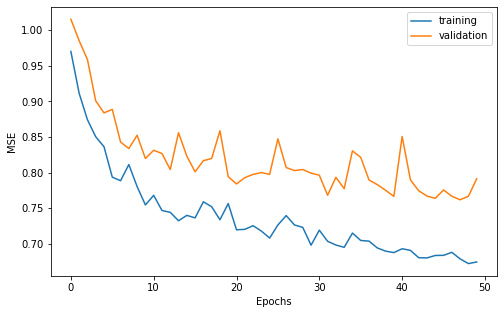

In [9]:
width = 8
height = width/1.618
plt.figure(figsize=(width, height))

plt.plot(history["loss"], label="training")
plt.plot(history["val_loss"], label="validation")

plt.xlabel("Epochs")
plt.ylabel("MSE")

plt.legend()

plt.show()

Also, let us look at the prediction on the test set.

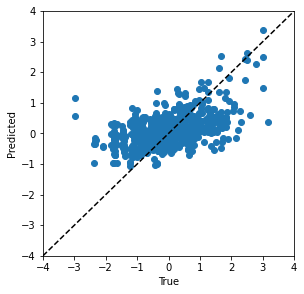

In [15]:
model.load_weights('gnn_model.h5')
pred_ty = model.predict(tx)

width = 4.5
height = width
plt.figure(figsize=(width, height))

vmin, vmax = -4, 4
plt.scatter(ty, pred_ty)
plt.plot([vmin, vmax], [vmin, vmax], 'k--')
plt.xlim([vmin, vmax])
plt.ylim([vmin, vmax])
plt.xlabel('True')
plt.ylabel('Predicted')

plt.show()

## Define the Neural Architecture Search Space <a class="anchor" id="define-the-neural-architecture-search-space"></a>

The neural architecture search space is composed of discrete decision variables. For each decision variable we choose among a list of possible operation to perform (e.g., fully connected, ReLU). To define this search space, it is necessary to use two classes:

* `KSearchSpace` (for Keras Search Space): represents a directed acyclic graph (DAG) in which each node represents a chosen operation. It represents the possible neural networks that can be created.
* `SpaceFactory`: is a utilitiy class used to pack the logic of a search space definition and share it with others.

Then, inside a `KSearchSpace` we will have two types of nodes:
* `VariableNode`: corresponds to discrete decision variables and are used to define a list of possible operation.
* `ConstantNode`: corresponds to fixed operation in the search space (e.g., input/outputs)

Finally, it is possible to reuse any `tf.keras.layers` to define a `KSearchSpace`. However, it is important to wrap each layer in an `operation` to perform a lazy memory allocation of tensors.

We implement the constructor `__init__` and `build` method of the `RegressionSpace` a subclass of `KSearchSpace`. The `__init__` method interface is:

```python
def __init__(self, input_shape, output_shape, **kwargs):
    ...
```

for the `build` method the interface is:

```python
def build(self):
    ...
    return self
```

where:
* `input_shape` corresponds to a tuple or a list of tuple indicating the shapes of inputs tensors.
* `output_shape` corresponds to the same but of output_tensors.
* `**kwargs` denotes that any other key word argument can be defined by the user.

In [7]:
import collections, itertools
import tensorflow as tf
from deephyper.nas import KSearchSpace
from deephyper.nas.node import ConstantNode, VariableNode
from deephyper.nas.operation import operation, Zero, Connect, AddByProjecting, Identity

Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense

class RegressionSpace(KSearchSpace):

    def __init__(self, input_shape, output_shape, seed=None, num_layers=3):
        super().__init__(input_shape, output_shape, seed=seed)
        self.num_layers = 3

    def build(self):
        out_sub_graph = self.build_sub_graph(self.input_nodes, self.num_layers)
        output = ConstantNode(op=Dense(self.output_shape[0]))
        self.connect(out_sub_graph, output)
        return self

    def build_sub_graph(self, input_nodes, num_layers=3):
        source = prev_input = input_nodes[0]
        prev_input1 = input_nodes[1]
        prev_input2 = input_nodes[2]
        prev_input3 = input_nodes[3]
        prev_input4 = input_nodes[4]
        
        anchor_points = collections.deque([source], maxlen=3)
        
        for _ in range(num_layers):
            graph_attn_cell = VariableNode()
            self.mpnn_cell(graph_attn_cell)
            self.connect(prev_input, graph_attn_cell)
            self.connect(prev_input1, graph_attn_cell)
            self.connect(prev_input2, graph_attn_cell)
            self.connect(prev_input3, graph_attn_cell)
            self.connect(prev_input4, graph_attn_cell)

            merge = ConstantNode()
            merge.set_op(AddByProjecting(self, [graph_attn_cell], activation="relu"))
            
            for node in anchor_points:
                skipco = VariableNode()
                skipco.add_op(Zero())
                skipco.add_op(Connect(self, node))
                self.connect(skipco, merge)

            prev_input = merge

            anchor_points.append(prev_input)
            
        global_pooling_node = VariableNode()
        self.gather_cell(global_pooling_node)
        self.connect(prev_input, global_pooling_node)
        prev_input = global_pooling_node

        flatten_node = ConstantNode()
        flatten_node.set_op(Flatten())
        self.connect(prev_input, flatten_node)
        prev_input = flatten_node

        return prev_input
                
    def mpnn_cell(self, node):
        state_dims = [4, 8, 16, 32]
        Ts = [1, 2, 3, 4]
        attn_methods = ["const", "gat", "sym-gat", "linear", "gen-linear", "cos"]
        attn_heads = [1, 2, 4, 6]
        aggr_methods = ["max", "mean", "sum"]
        update_methods = ["gru", "mlp"]
        activations = [tf.keras.activations.sigmoid,
                       tf.keras.activations.tanh,
                       tf.keras.activations.relu,
                       tf.keras.activations.linear,
                       tf.keras.activations.elu,
                       tf.keras.activations.softplus,
                       tf.nn.leaky_relu,
                       tf.nn.relu6]

        for hp in itertools.product(state_dims,
                                    Ts,
                                    attn_methods,
                                    attn_heads,
                                    aggr_methods,
                                    update_methods,
                                    activations):
            (state_dim, T, attn_method, attn_head, aggr_method, update_method, activation) = hp
            
            node.add_op(SPARSE_MPNN(state_dim=state_dim,
                                    T=T,
                                    attn_method=attn_method,
                                    attn_head=attn_head,
                                    aggr_method=aggr_method,
                                    update_method=update_method,
                                    activation=activation))
            
    def gather_cell(self, node):
        for functions in [GlobalSumPool, GlobalMaxPool, GlobalAvgPool]:
            for axis in [-1, -2]:
                node.add_op(functions(axis=axis))
        node.add_op(Flatten())
        
        for state_dim in [16, 32, 64]:
            node.add_op(GlobalAttentionPool(state_dim=state_dim))
        node.add_op(GlobalAttentionSumPool())

Let us visualize a few randomly sampled neural architecture from this search space.

2021-11-06 18:27:52.212386: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


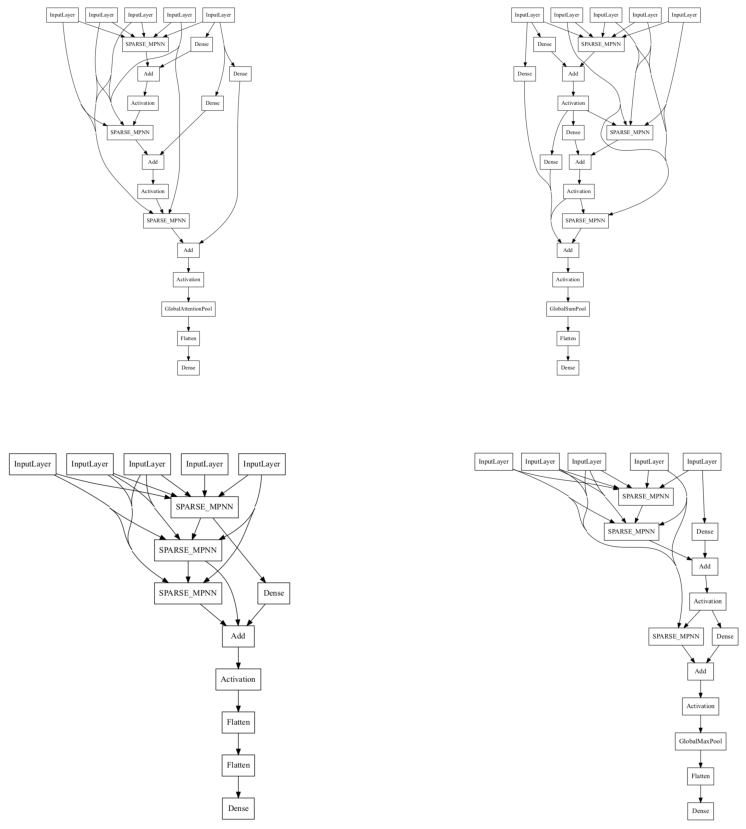

In [23]:
import matplotlib.image as mpimg
from tensorflow.keras.utils import plot_model

input_shape = [item.shape[1:] for item in x]
output_shape = y.shape[1:]
shapes = dict(input_shape=input_shape, output_shape=output_shape)
space = RegressionSpace(**shapes).build()
    

images = []
plt.figure(figsize=(15,15))
for i in range(4):
    
    model = space.sample()
    plt.subplot(2,2,i+1)
    plot_model(model, "random_model.png", show_shapes=False, show_layer_names=False)
    image = mpimg.imread("random_model.png")
    plt.imshow(image)
    plt.axis('off')

plt.show()

## Define the Neural Architecture Optimization Problem <a class="anchor" id="define-the-neural-architecture-search-optimization-problem"></a>

In order to define a neural architecture search problem we have to use the `NaProblem` class. This class gives access to different method for the user to customize the training settings of neural networks.

In [8]:
from deephyper.problem import NaProblem

problem = NaProblem()

# Bind a function which returns (train_input, train_output), (valid_input, valid_output)
problem.load_data(load_data)

# Bind a function which returns a search space and give some arguments for the `build` method
problem.search_space(RegressionSpace, num_layers=3)

# Define a set of fixed hyperparameters for all trained neural networks
problem.hyperparameters(
    batch_size=128,
    learning_rate=1e-3,
    optimizer="adam",
    num_epochs=1,
    callbacks=dict(
        EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=1)
    ),
)

# Define the loss to minimize
problem.loss("mse")

# Define complementary metrics
problem.metrics([])

# Define the maximized objective. Here we take the negative of the validation loss.
problem.objective("-val_loss")

problem

Problem is:
    - search space   : __main__.RegressionSpace
    - data loading   : __main__.load_data
    - preprocessing  : None
    - hyperparameters: 
        * verbose: 0
        * batch_size: 128
        * learning_rate: 0.001
        * optimizer: adam
        * num_epochs: 1
        * callbacks: {'EarlyStopping': {'monitor': 'val_loss', 'mode': 'min', 'verbose': 0, 'patience': 1}}
    - loss           : mse
    - metrics        : 
    - objective      : -val_loss

<div class="alert alert-info">
    
<b>Tip</b>
    
Adding an `EarlyStopping(...)` callback is a good idea to stop the training of your model as soon as it stops to improve.

```python
...
EarlyStopping=dict(monitor="val_loss", mode="min", verbose=0, patience=3)
...
```
    
</div>



## Define the Evaluator Object

The `Evaluator` object is responsible of defining the backend used to distribute the function evaluation in DeepHyper.

In [9]:
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import LoggerCallback


def get_evaluator(run_function):
    
    # Default arguments for Ray: 1 worker and 1 worker per evaluation
    method_kwargs = {
        "num_cpus": 1, 
        "num_cpus_per_task": 1,
        "callbacks": [LoggerCallback()] # To interactively follow the finished evaluations,
    }

    # If GPU devices are detected then it will create 'n_gpus' workers
    # and use 1 worker for each evaluation
    if is_gpu_available:
        method_kwargs["num_cpus"] = n_gpus
        method_kwargs["num_gpus"] = n_gpus
        method_kwargs["num_cpus_per_task"] = 1
        method_kwargs["num_gpus_per_task"] = 1

    evaluator = Evaluator.create(
        run_function, 
        method="ray", 
        method_kwargs=method_kwargs
    )
    print(f"Created new evaluator with {evaluator.num_workers} worker{'s' if evaluator.num_workers > 1 else ''} and config: {method_kwargs}", )
    
    return evaluator

For neural architecture search a standard training pipeline is provided by the `run_base_trainer` function from the `deephyper.nas.run` module.

In [10]:
from deephyper.nas.run import run_base_trainer

## Define and Run the Neural Architecture Search

All search algorithms follow a similar interface. A `problem` and `evaluator` object has to be provided to the search then the search can be executed through the `search(max_evals, timeout)` method.

In [11]:
results = {} # used to store the results of different search algorithms
max_evals = 10 # maximum number of iteratins for all searches

In [12]:
from deephyper.search.nas import Random

random_search = Random(problem, get_evaluator(run_base_trainer), log_dir="random_search")

results["random"] = random_search.search(max_evals=max_evals)

Created new evaluator with 4 workers and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7fb96748b8e0>]}
[00001] -- best objective: -1.07081 -- received objective: -1.07081
[00002] -- best objective: -1.05553 -- received objective: -1.05553
[00003] -- best objective: -1.03785 -- received objective: -1.03785
[00004] -- best objective: -1.03785 -- received objective: -1.06099
[00005] -- best objective: -1.03785 -- received objective: -1.08404
[00006] -- best objective: -1.03785 -- received objective: -1.06783
[00007] -- best objective: -1.03785 -- received objective: -1.12270
[00008] -- best objective: -1.03785 -- received objective: -1.06450
[00009] -- best objective: -1.03785 -- received objective: -1.06815
[00010] -- best objective: -1.03785 -- received objective: -1.12872


By default, the `RegularizedEvolution` has a population size of 100 therefore, it will start optimizing only after 100 evaluations.

In [13]:
from deephyper.search.nas import RegularizedEvolution

regevo_search = RegularizedEvolution(problem, get_evaluator(run_base_trainer), log_dir="regevo_search")

results["regevo"] = regevo_search.search(max_evals=max_evals)

Created new evaluator with 4 workers and config: {'num_cpus': 1, 'num_cpus_per_task': 1, 'callbacks': [<deephyper.evaluator.callback.LoggerCallback object at 0x7fb97b4597c0>]}
[00001] -- best objective: -0.93681 -- received objective: -0.93681
[00002] -- best objective: -0.93681 -- received objective: -1.05142
[00003] -- best objective: -0.93681 -- received objective: -1.60668
[00004] -- best objective: -0.93681 -- received objective: -1.06182
[00005] -- best objective: -0.93681 -- received objective: -1.06850
[00006] -- best objective: -0.93681 -- received objective: -1.22729
[00007] -- best objective: -0.93681 -- received objective: -1.05649
[00008] -- best objective: -0.93681 -- received objective: -1.06746
[00009] -- best objective: -0.93681 -- received objective: -1.06470
[00010] -- best objective: -0.93681 -- received objective: -1.04246


We can now compare the search trajectories for different algorithms.

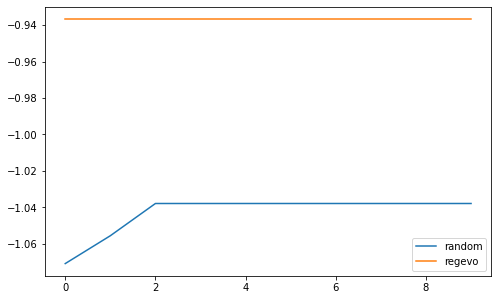

In [14]:
def max_score(l):
    r = [l[0]]
    for el in l[1:]:
        r.append(max(r[-1], el))
    return r

width = 8
height = width/1.618
plt.figure(figsize=(width, height))

for k, result in results.items():
    plt.plot(max_score(results[k].objective), label=k)
    
plt.legend()
    
plt.show()

If we look at the dataframe of results for each search we will find it slightly different than the one of hyperparameter search. A new column `arch_seq` corresponds to an embedding for each evaluated architecture. Each integer of an `arch_seq` list corresponds to the choice of a `VariableNode` in our `KSearchSpace`.

In [15]:
results["random"]

,arch_seq,id,objective,elapsed_sec,duration
0,"[8345, 0, 4729, 1, 0, 4861, 1, 1, 0, 4]",3,-1.070806,133.624194,114.242286
1,"[8344, 1, 4826, 0, 1, 4023, 1, 1, 0, 5]",1,-1.055530,202.216382,182.834587
2,"[15815, 0, 9637, 1, 1, 6884, 0, 0, 1, 2]",2,-1.037854,247.273078,227.891224
3,"[10254, 1, 17913, 0, 0, 7103, 0, 1, 0, 5]",4,-1.060989,348.632165,329.250206
4,"[658, 0, 7223, 1, 0, 13837, 1, 0, 0, 4]",7,-1.084036,421.581393,174.304056
5,"[1939, 0, 700, 0, 0, 186, 0, 0, 0, 5]",8,-1.067830,467.828731,119.194764
6,"[14176, 0, 4205, 0, 1, 12915, 1, 0, 1, 8]",6,-1.122700,729.348014,527.129644
7,"[5820, 1, 16807, 0, 1, 7316, 0, 0, 0, 10]",5,-1.064504,758.794226,625.166945
8,"[3792, 1, 2654, 1, 1, 14744, 0, 0, 0, 4]",9,-1.068154,860.098097,438.514493
9,"[9690, 0, 14960, 0, 0, 7065, 1, 0, 0, 9]",10,-1.128725,957.735303,489.904746


Let us visualize the best architecture found:

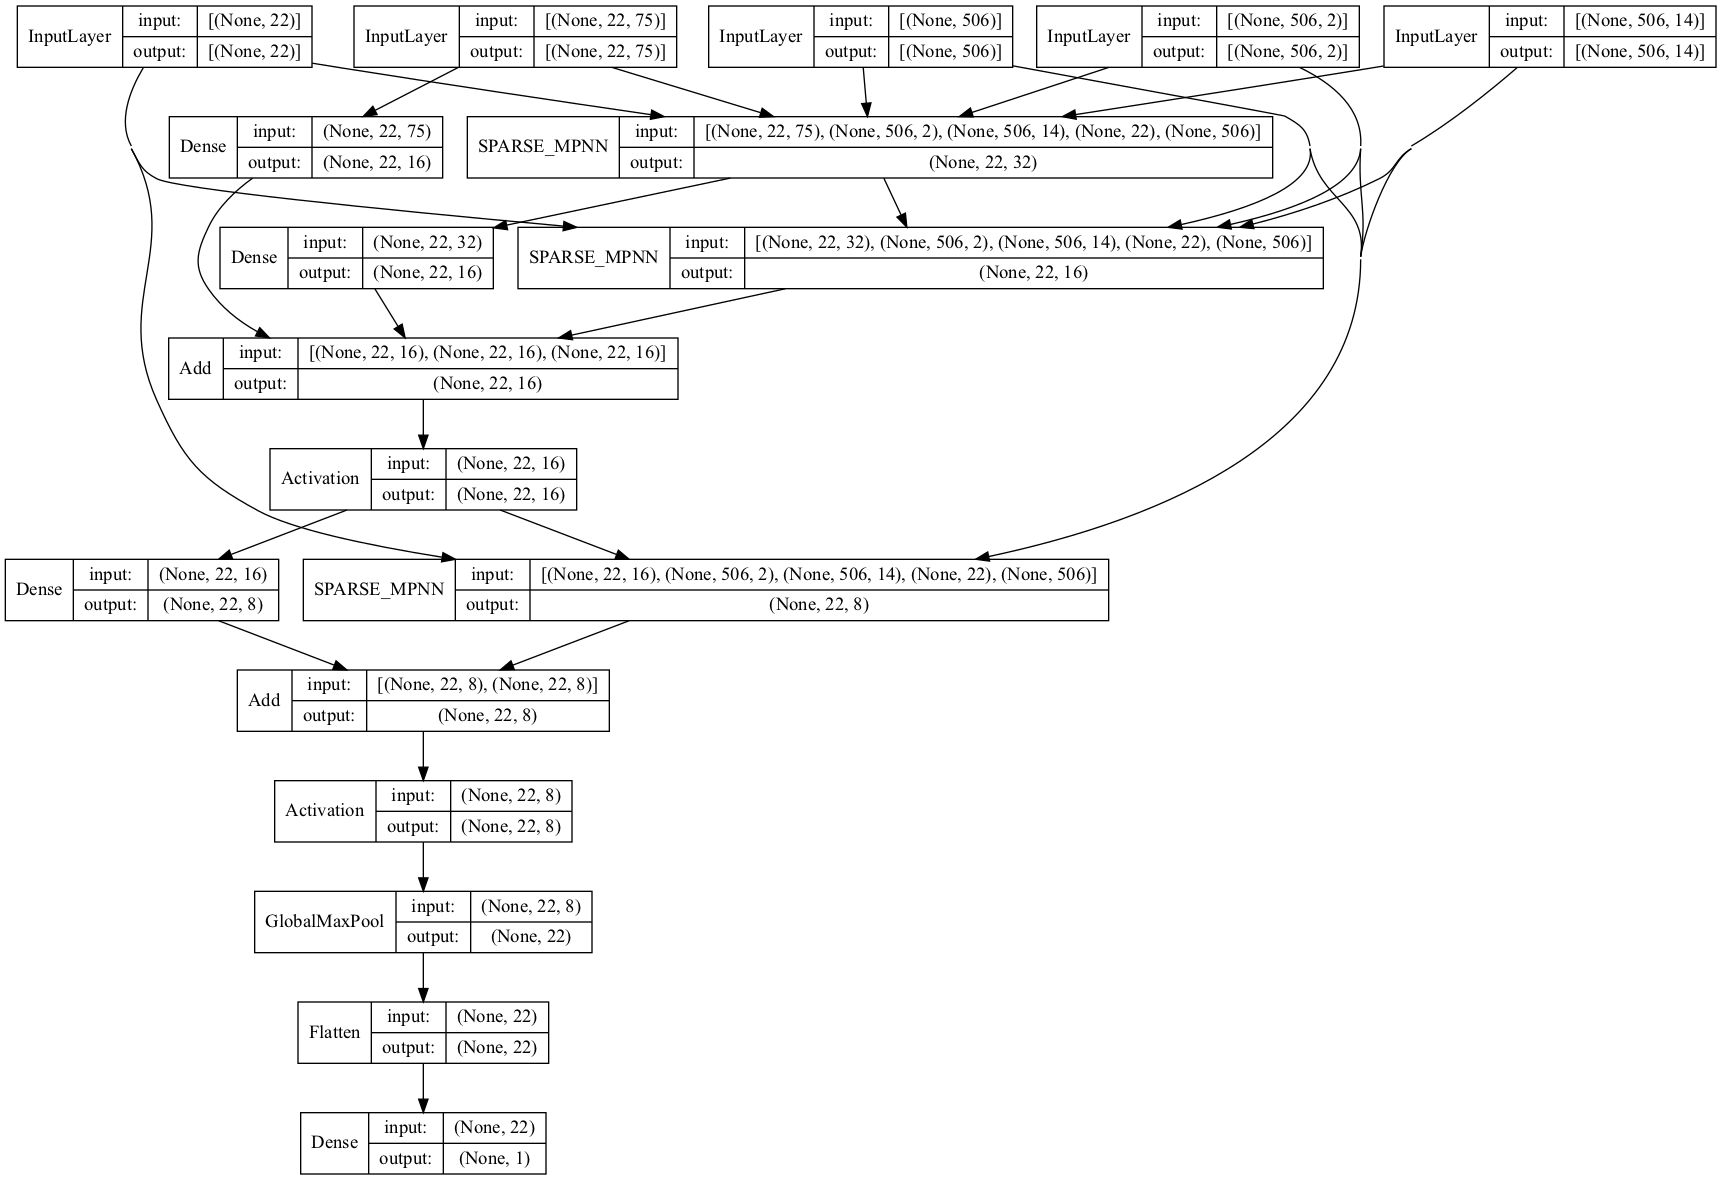

In [25]:
i_max = results["random"].objective.argmax()
best_score = results["random"].iloc[i_max].objective
best_arch_seq = json.loads(results["random"].iloc[i_max].arch_seq)

best_model = space.sample(best_arch_seq)
plot_model(best_model, show_shapes=True, show_layer_names=False)